Using device: cuda
Found 74 images in the test set.
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth

EVALUATING: DinoV3


Testing DinoV3: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]



Results for DinoV3:
  -> Overall Accuracy: 0.8514 (85.14%)
  -> Laryngitis Accuracy: 69.23%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6429    0.6923    0.6667        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8889    0.6154    0.7273        13

              accuracy                         0.8514        74
             macro avg     0.8546    0.8590    0.8495        74
          weighted avg     0.8603    0.8514    0.8491        74



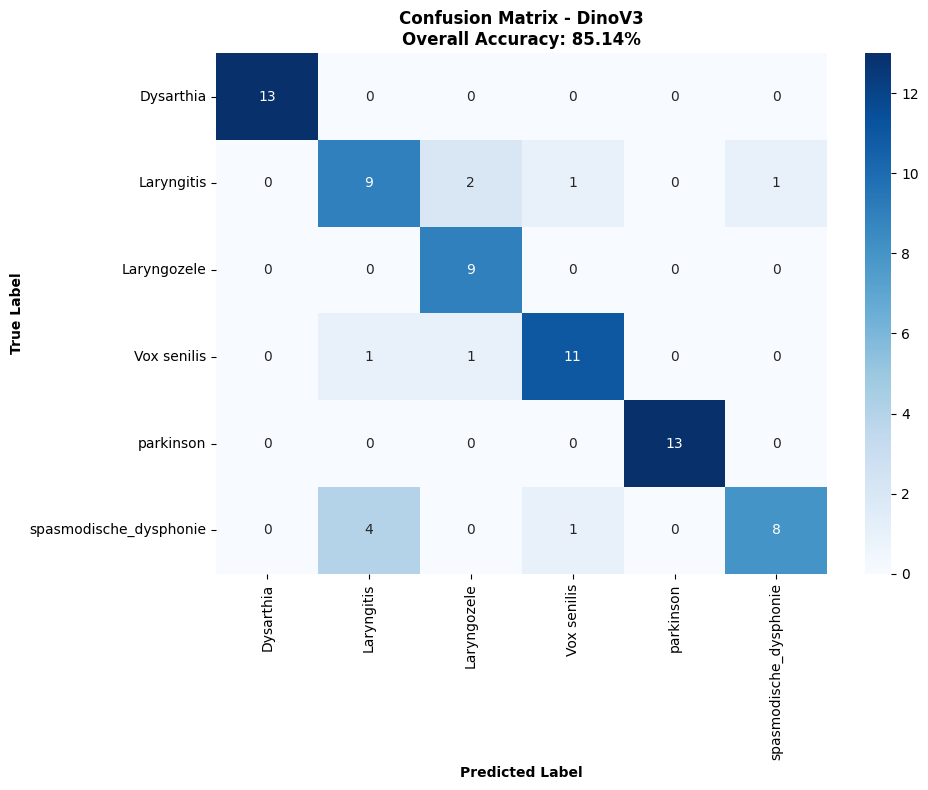

✅ Loaded weights for Eva from: best_finetuned_model.pth

EVALUATING: EVA-02


Testing EVA-02: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Results for EVA-02:
  -> Overall Accuracy: 0.7703 (77.03%)
  -> Laryngitis Accuracy: 46.15%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.4615    0.5217        13
           Laryngozele     0.6667    0.8889    0.7619         9
           Vox senilis     0.7143    0.7692    0.7407        13
             parkinson     0.9286    1.0000    0.9630        13
spasmodische_dysphonie     0.6364    0.5385    0.5833        13

              accuracy                         0.7703        74
             macro avg     0.7576    0.7764    0.7618        74
          weighted avg     0.7626    0.7703    0.7618        74



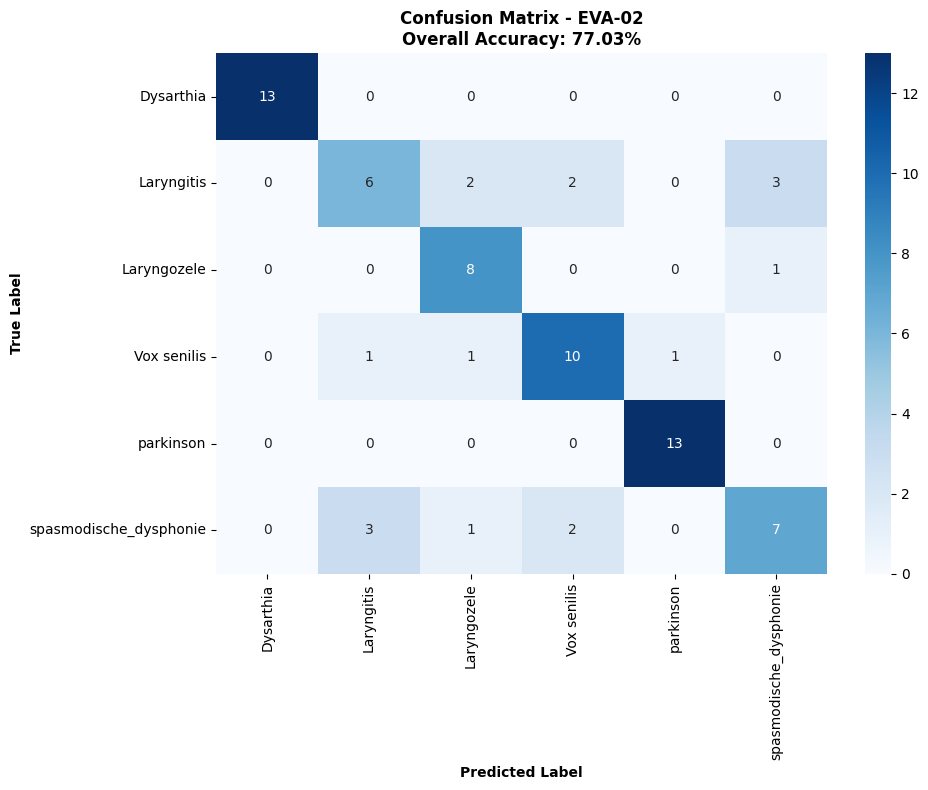

✅ Loaded weights for TimmClassifier from: best_full_model.pth

EVALUATING: MaxViT


Testing MaxViT: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]



Results for MaxViT:
  -> Overall Accuracy: 0.8514 (85.14%)
  -> Laryngitis Accuracy: 69.23%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7000    0.7778    0.7368         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8333    0.7692    0.8000        13

              accuracy                         0.8514        74
             macro avg     0.8453    0.8476    0.8459        74
          weighted avg     0.8532    0.8514    0.8518        74



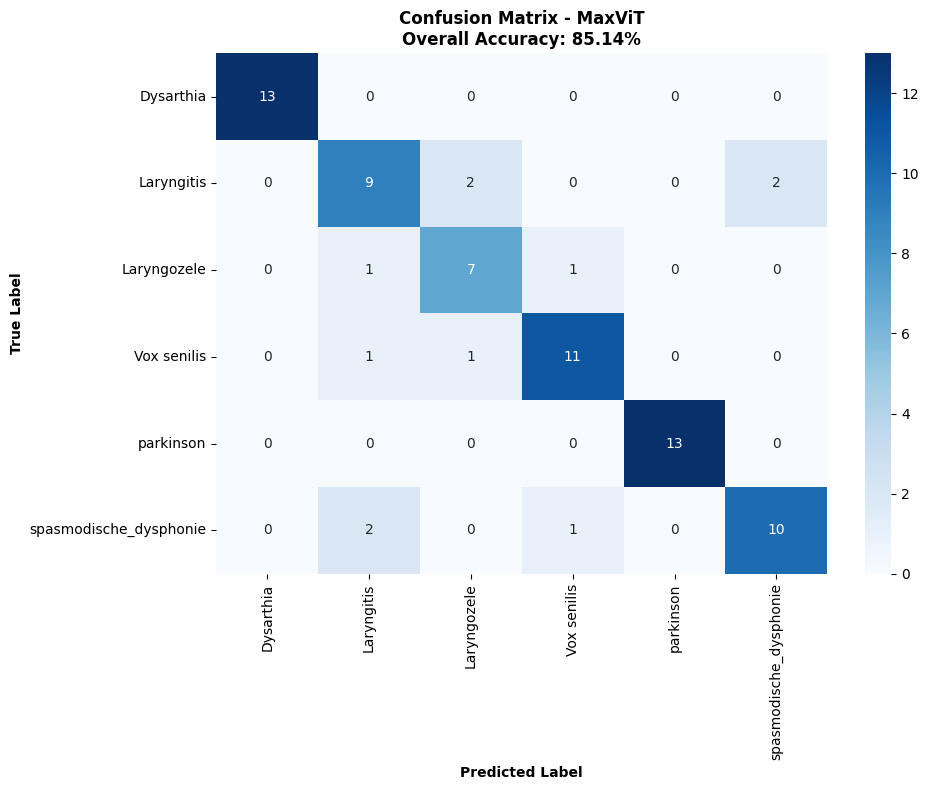


FINAL INDIVIDUAL MODEL ACCURACY SUMMARY
DinoV3    : 85.14%
MaxViT    : 85.14%
EVA-02    : 77.03%


In [1]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names (CORRECTED) ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m', # Hugging Face ID
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k', # timm ID
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k', # timm ID

    ## TODO: UPDATE THESE PATHS to your best-saved models from training.
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL AND HELPER DEFINITIONS
# =============================================================================

# Custom wrapper class for the DinoV3 model
class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

# Custom wrapper class for the MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

def get_test_loader(base_dir, img_size, batch_size, num_workers):
    """Creates a DataLoader for the test set."""
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(test_dataset)} images in the test set.")
    return test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    """Robustly loads weights from either a checkpoint dict or a direct state_dict."""
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

def evaluate_single_model(model, model_name, test_loader, class_names, device):
    """Runs a full evaluation on a single model and prints a detailed report."""
    print(f"\n{'='*60}\nEVALUATING: {model_name}\n{'='*60}")
    model.to(device)
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    laryngitis_idx = class_names.index('Laryngitis')
    true_arr, pred_arr = np.array(all_labels), np.array(all_preds)
    laryngitis_mask = true_arr == laryngitis_idx
    laryngitis_acc = accuracy_score(true_arr[laryngitis_mask], pred_arr[laryngitis_mask]) if laryngitis_mask.any() else 0
    
    print(f"\nResults for {model_name}:")
    print(f"  -> Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    print(f"  -> Laryngitis Accuracy: {laryngitis_acc:.2%}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}\nOverall Accuracy: {accuracy:.2%}', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold'); plt.ylabel('True Label', fontweight='bold')
    plt.tight_layout()
    plt.show()
    return accuracy

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    # --- Step 1: Load Data ---
    test_loader, class_names = get_test_loader(config['base_dir'], config['img_size'], config['batch_size'], config['num_workers'])
    num_classes = len(class_names)
    
    results = {}

    # --- Step 2: Evaluate DinoV3 ---
    dino_model = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(dino_model, config['dino_model_path'], device)
    acc_dino = evaluate_single_model(dino_model, "DinoV3", test_loader, class_names, device)
    results['DinoV3'] = acc_dino

    # --- Step 3: Evaluate EVA-02 ---
    eva_model = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(eva_model, config['eva_model_path'], device)
    acc_eva = evaluate_single_model(eva_model, "EVA-02", test_loader, class_names, device)
    results['EVA-02'] = acc_eva
    
    # --- Step 4: Evaluate MaxViT ---
    maxvit_model = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(maxvit_model, config['maxvit_model_path'], device)
    acc_maxvit = evaluate_single_model(maxvit_model, "MaxViT", test_loader, class_names, device)
    results['MaxViT'] = acc_maxvit

    # --- Step 5: Print Final Summary ---
    print("\n" + "="*60)
    print("FINAL INDIVIDUAL MODEL ACCURACY SUMMARY")
    print("="*60)
    for name, acc in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print(f"{name:<10}: {acc:.2%}")

In [3]:
import torch
import os

# --- MODEL HEALTH CHECK SCRIPT ---

# TODO: Update this path to the file you want to inspect.
# Start by checking your 'best_finetuned_model.pth' file.
file_path_to_check = r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth'

print(f"--- Inspecting Model File ---")
print(f"File: {os.path.basename(file_path_to_check)}")

try:
    # Load the file safely to the CPU
    checkpoint = torch.load(file_path_to_check, map_location='cpu')

    # Check if it's a checkpoint dictionary with a saved accuracy score
    if 'val_acc' in checkpoint:
        saved_accuracy = checkpoint['val_acc']
        print(f"\n[ RESULT ]")
        print(f"This file is a CHECKPOINT.")
        print(f"The validation accuracy saved inside is: {saved_accuracy:.4f} ({saved_accuracy:.2%})")

        # Give a clear verdict based on the accuracy
        if 0.84 < saved_accuracy:
             print("\n>>> VERDICT: This IS your STRONG (84.93%) model file. <<<")
        elif 0.77 < saved_accuracy < 0.78:
             print("\n>>> VERDICT: This is your WEAK (77.03%) model file. <<<")
        else:
             print("\n>>> VERDICT: This file contains a model with an unrecognized accuracy. <<<")

    # Check if it's just a state_dict without an accuracy score
    elif 'model_state_dict' not in checkpoint and any('weight' in k for k in checkpoint.keys()):
        print(f"\n[ RESULT ]")
        print("This file appears to be a direct STATE_DICT (contains only weights).")
        print("It does not have an accuracy score saved inside it.")
        print("\n>>> VERDICT: This is likely one of your OLDER model files. <<<")

    else:
        print("\n[ RESULT ]")
        print("The structure of this file is unrecognized.")

except FileNotFoundError:
    print("\n[ ERROR ]: File not found. Please double-check the path and filename.")
except Exception as e:
    print(f"\n[ ERROR ]: An error occurred while reading the file: {e}")

--- Inspecting Model File ---
File: best_finetuned_model.pth

[ RESULT ]
This file is a CHECKPOINT.
The validation accuracy saved inside is: 0.8493 (84.93%)

>>> VERDICT: This IS your STRONG (84.93%) model file. <<<


Using device: cuda
Found 74 images in the test set.
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth

EVALUATING: DinoV3


Testing DinoV3: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]



Results for DinoV3:
  -> Overall Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6429    0.6923    0.6667        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8889    0.6154    0.7273        13

              accuracy                         0.8514        74
             macro avg     0.8546    0.8590    0.8495        74
          weighted avg     0.8603    0.8514    0.8491        74



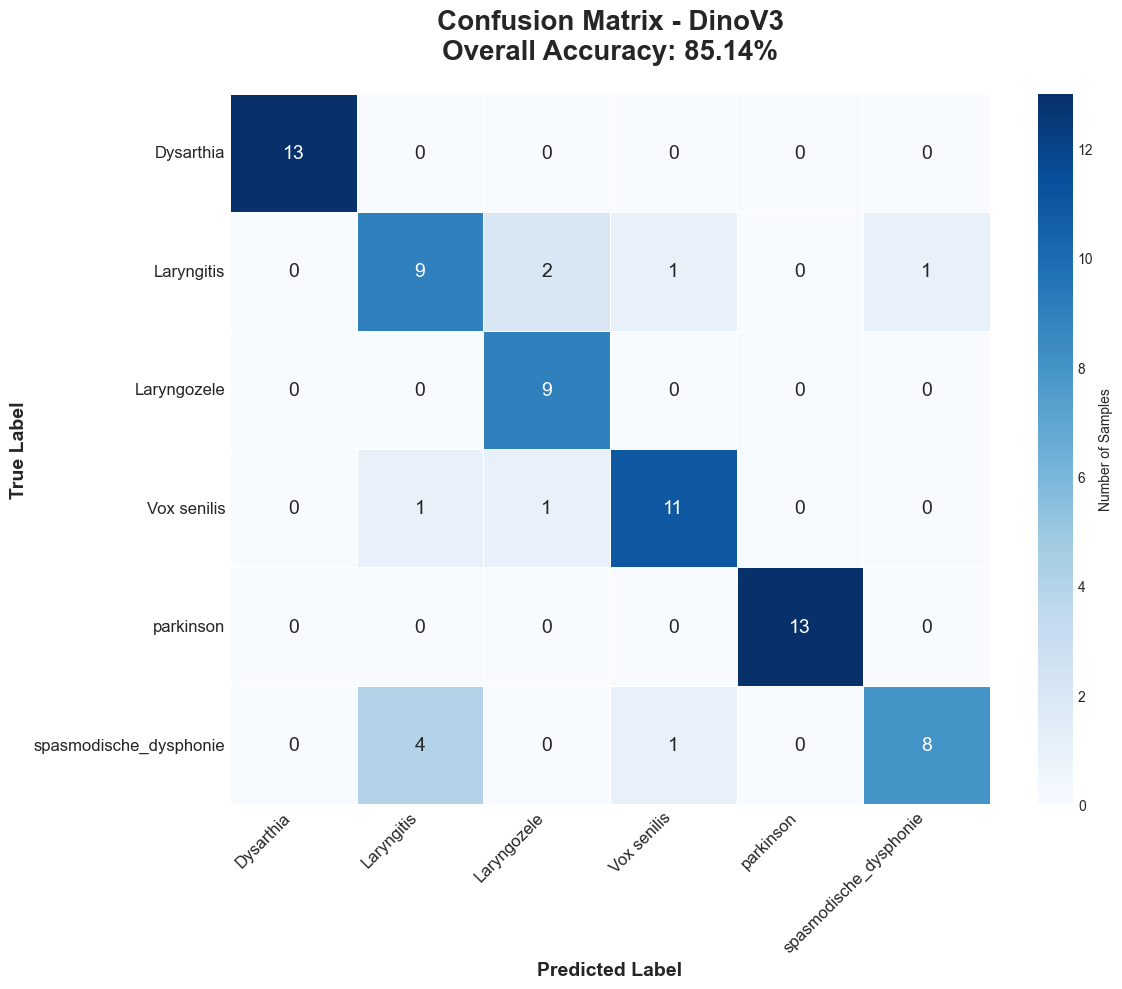

🖼️  HD Confusion Matrix saved to 'confusion_matrix_DinoV3_hd.png'
✅ Loaded weights for Eva from: best_finetuned_model.pth

EVALUATING: EVA-02


Testing EVA-02: 100%|██████████| 5/5 [00:00<00:00,  8.80it/s]



Results for EVA-02:
  -> Overall Accuracy: 0.7703 (77.03%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.4615    0.5217        13
           Laryngozele     0.6667    0.8889    0.7619         9
           Vox senilis     0.7143    0.7692    0.7407        13
             parkinson     0.9286    1.0000    0.9630        13
spasmodische_dysphonie     0.6364    0.5385    0.5833        13

              accuracy                         0.7703        74
             macro avg     0.7576    0.7764    0.7618        74
          weighted avg     0.7626    0.7703    0.7618        74



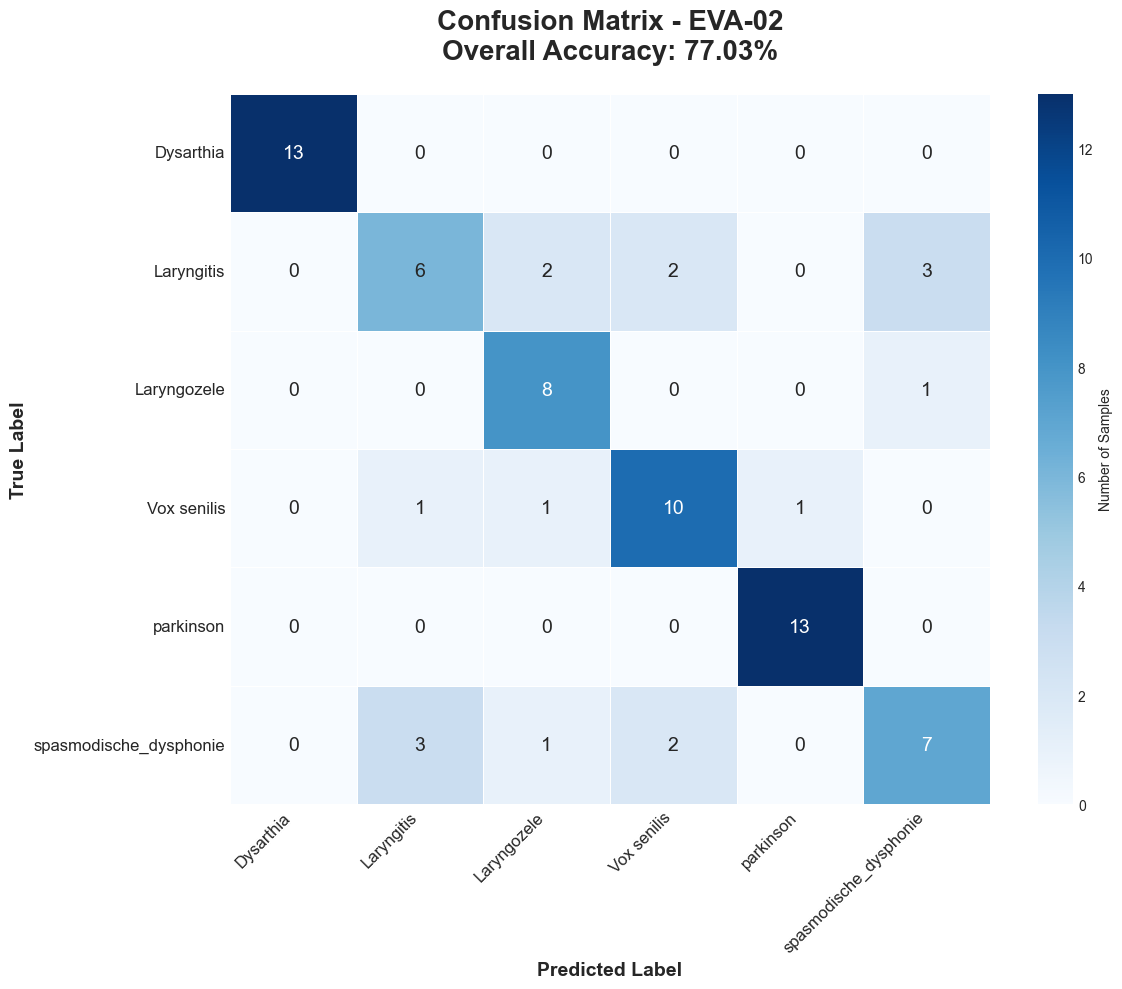

🖼️  HD Confusion Matrix saved to 'confusion_matrix_EVA-02_hd.png'
✅ Loaded weights for TimmClassifier from: best_full_model.pth

EVALUATING: MaxViT


Testing MaxViT: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]



Results for MaxViT:
  -> Overall Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7000    0.7778    0.7368         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8333    0.7692    0.8000        13

              accuracy                         0.8514        74
             macro avg     0.8453    0.8476    0.8459        74
          weighted avg     0.8532    0.8514    0.8518        74



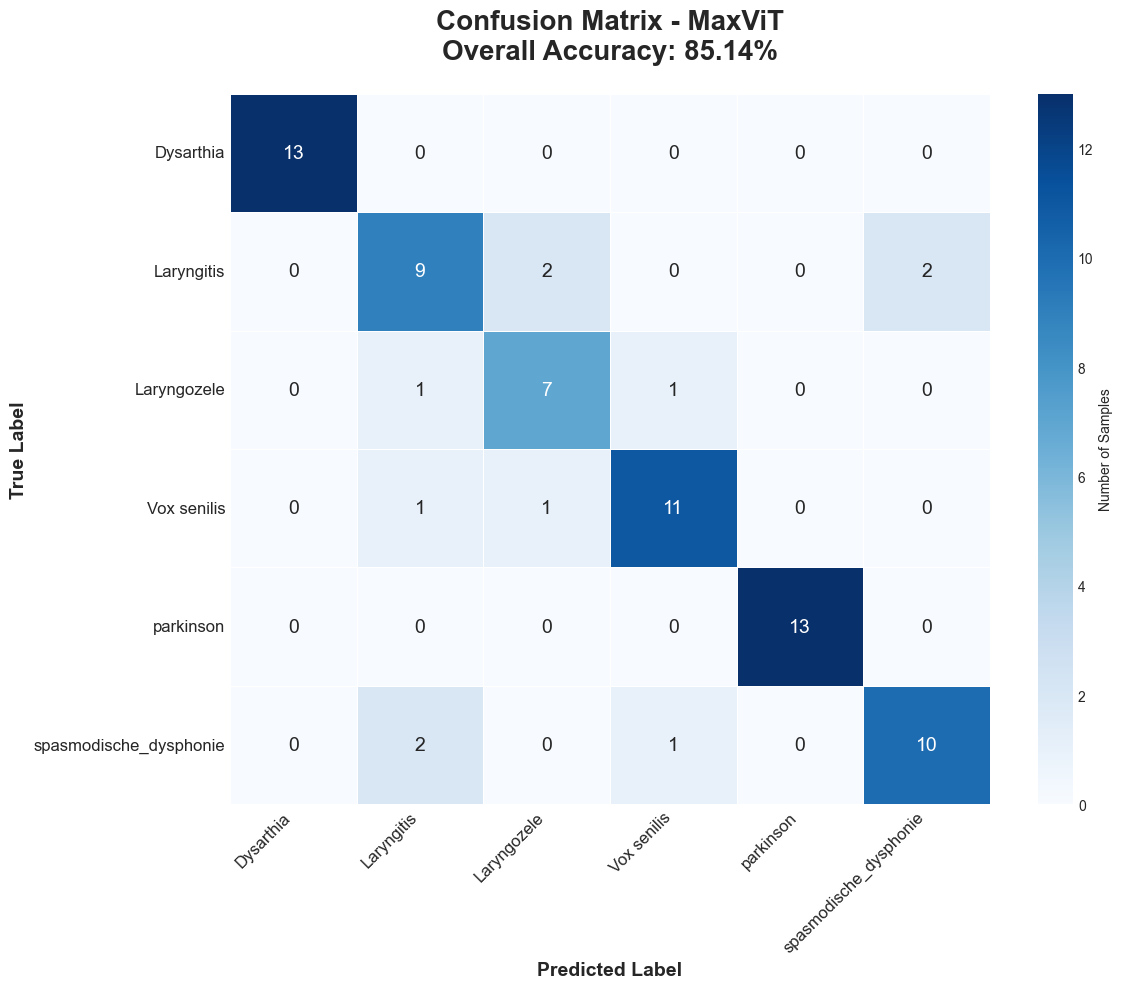

🖼️  HD Confusion Matrix saved to 'confusion_matrix_MaxViT_hd.png'

FINAL INDIVIDUAL MODEL ACCURACY SUMMARY
DinoV3    : 85.14%
MaxViT    : 85.14%
EVA-02    : 77.03%


In [5]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL AND HELPER DEFINITIONS
# =============================================================================

class TransformersClassifier(nn.Module):
    # ... (class definition is unchanged)
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

class TimmClassifier(nn.Module):
    # ... (class definition is unchanged)
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

def get_test_loader(base_dir, img_size, batch_size, num_workers):
    # ... (function is unchanged)
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(test_dataset)} images in the test set.")
    return test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    # ... (function is unchanged)
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# --- NEW HD PLOTTING FUNCTION ---
def plot_hd_confusion_matrix(cm, class_names, model_name, accuracy):
    """Creates and saves a high-definition confusion matrix plot."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    
    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 14},
        linewidths=.5,
        cbar_kws={'label': 'Number of Samples'}
    )
    
    plt.title(f'Confusion Matrix - {model_name}\nOverall Accuracy: {accuracy:.2%}', fontsize=20, fontweight='bold', pad=25)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    
    plt.tight_layout()
    
    # Save the figure with high DPI
    save_path = f'confusion_matrix_{model_name}_hd.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"🖼️  HD Confusion Matrix saved to '{save_path}'")

def evaluate_single_model(model, model_name, test_loader, class_names, device):
    """Runs a full evaluation and calls the new HD plotting function."""
    print(f"\n{'='*60}\nEVALUATING: {model_name}\n{'='*60}")
    model.to(device)
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nResults for {model_name}:")
    print(f"  -> Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Calculate and plot the HD confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_hd_confusion_matrix(cm, class_names, model_name, accuracy)
    
    return accuracy

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    test_loader, class_names = get_test_loader(config['base_dir'], config['img_size'], config['batch_size'], config['num_workers'])
    num_classes = len(class_names)
    results = {}

    # --- Evaluate DinoV3 ---
    dino_model = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(dino_model, config['dino_model_path'], device)
    acc_dino = evaluate_single_model(dino_model, "DinoV3", test_loader, class_names, device)
    results['DinoV3'] = acc_dino

    # --- Evaluate EVA-02 ---
    eva_model = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(eva_model, config['eva_model_path'], device)
    acc_eva = evaluate_single_model(eva_model, "EVA-02", test_loader, class_names, device)
    results['EVA-02'] = acc_eva
    
    # --- Evaluate MaxViT ---
    maxvit_model = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(maxvit_model, config['maxvit_model_path'], device)
    acc_maxvit = evaluate_single_model(maxvit_model, "MaxViT", test_loader, class_names, device)
    results['MaxViT'] = acc_maxvit

    # --- Final Summary ---
    print("\n" + "="*60 + "\nFINAL INDIVIDUAL MODEL ACCURACY SUMMARY\n" + "="*60)
    for name, acc in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print(f"{name:<10}: {acc:.2%}")

Using device: cuda
Found 74 images in the test set.
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth

EVALUATING: DinoV3


Testing DinoV3: 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]



Results for DinoV3:
  -> Overall Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6429    0.6923    0.6667        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8889    0.6154    0.7273        13

              accuracy                         0.8514        74
             macro avg     0.8546    0.8590    0.8495        74
          weighted avg     0.8603    0.8514    0.8491        74



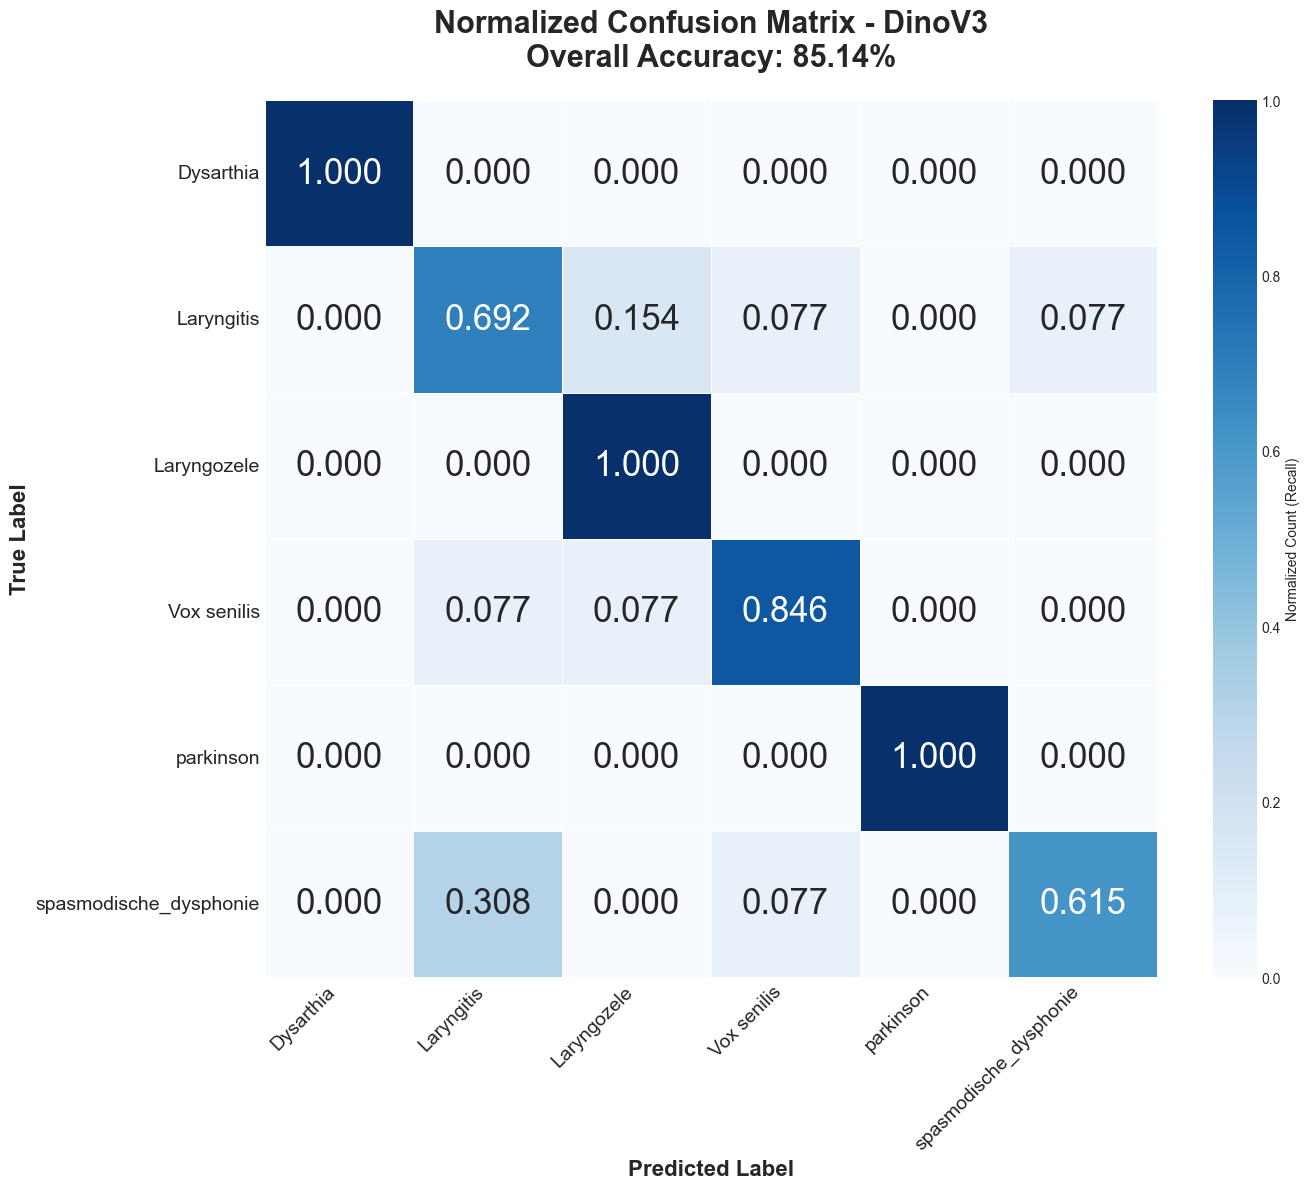

🖼️  HD Normalized Confusion Matrix saved to 'normalized_confusion_matrix_DinoV3_hd.png'
✅ Loaded weights for Eva from: best_finetuned_model.pth

EVALUATING: EVA-02


Testing EVA-02: 100%|██████████| 5/5 [00:00<00:00,  8.68it/s]



Results for EVA-02:
  -> Overall Accuracy: 0.7703 (77.03%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.4615    0.5217        13
           Laryngozele     0.6667    0.8889    0.7619         9
           Vox senilis     0.7143    0.7692    0.7407        13
             parkinson     0.9286    1.0000    0.9630        13
spasmodische_dysphonie     0.6364    0.5385    0.5833        13

              accuracy                         0.7703        74
             macro avg     0.7576    0.7764    0.7618        74
          weighted avg     0.7626    0.7703    0.7618        74



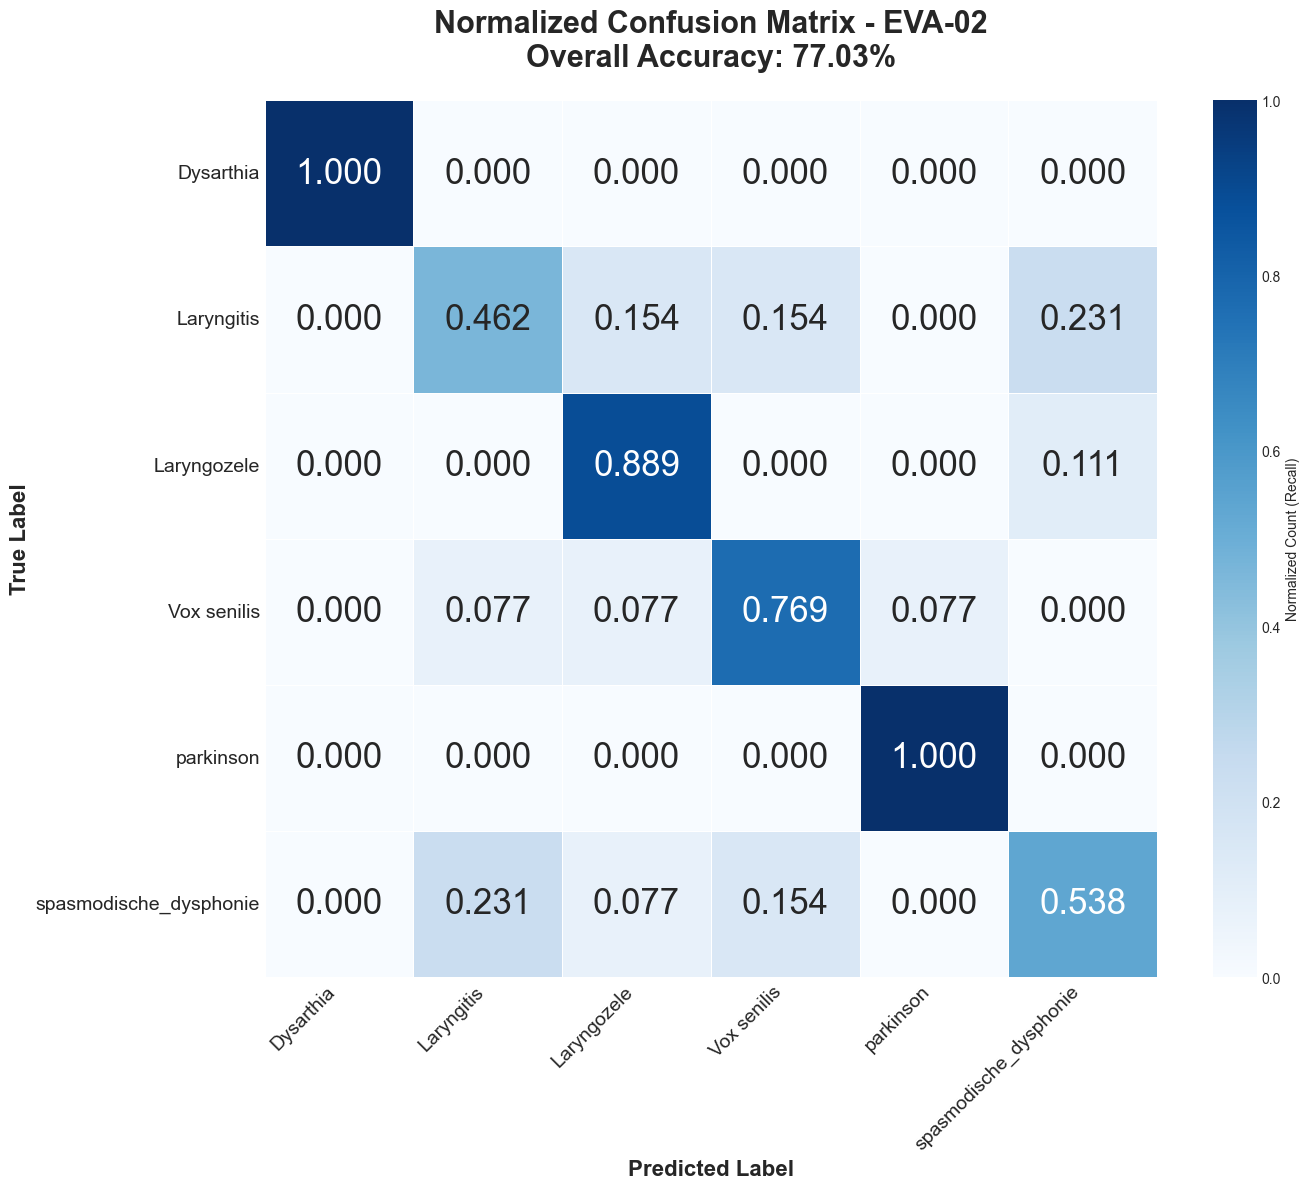

🖼️  HD Normalized Confusion Matrix saved to 'normalized_confusion_matrix_EVA-02_hd.png'
✅ Loaded weights for TimmClassifier from: best_full_model.pth

EVALUATING: MaxViT


Testing MaxViT: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]



Results for MaxViT:
  -> Overall Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7000    0.7778    0.7368         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8333    0.7692    0.8000        13

              accuracy                         0.8514        74
             macro avg     0.8453    0.8476    0.8459        74
          weighted avg     0.8532    0.8514    0.8518        74



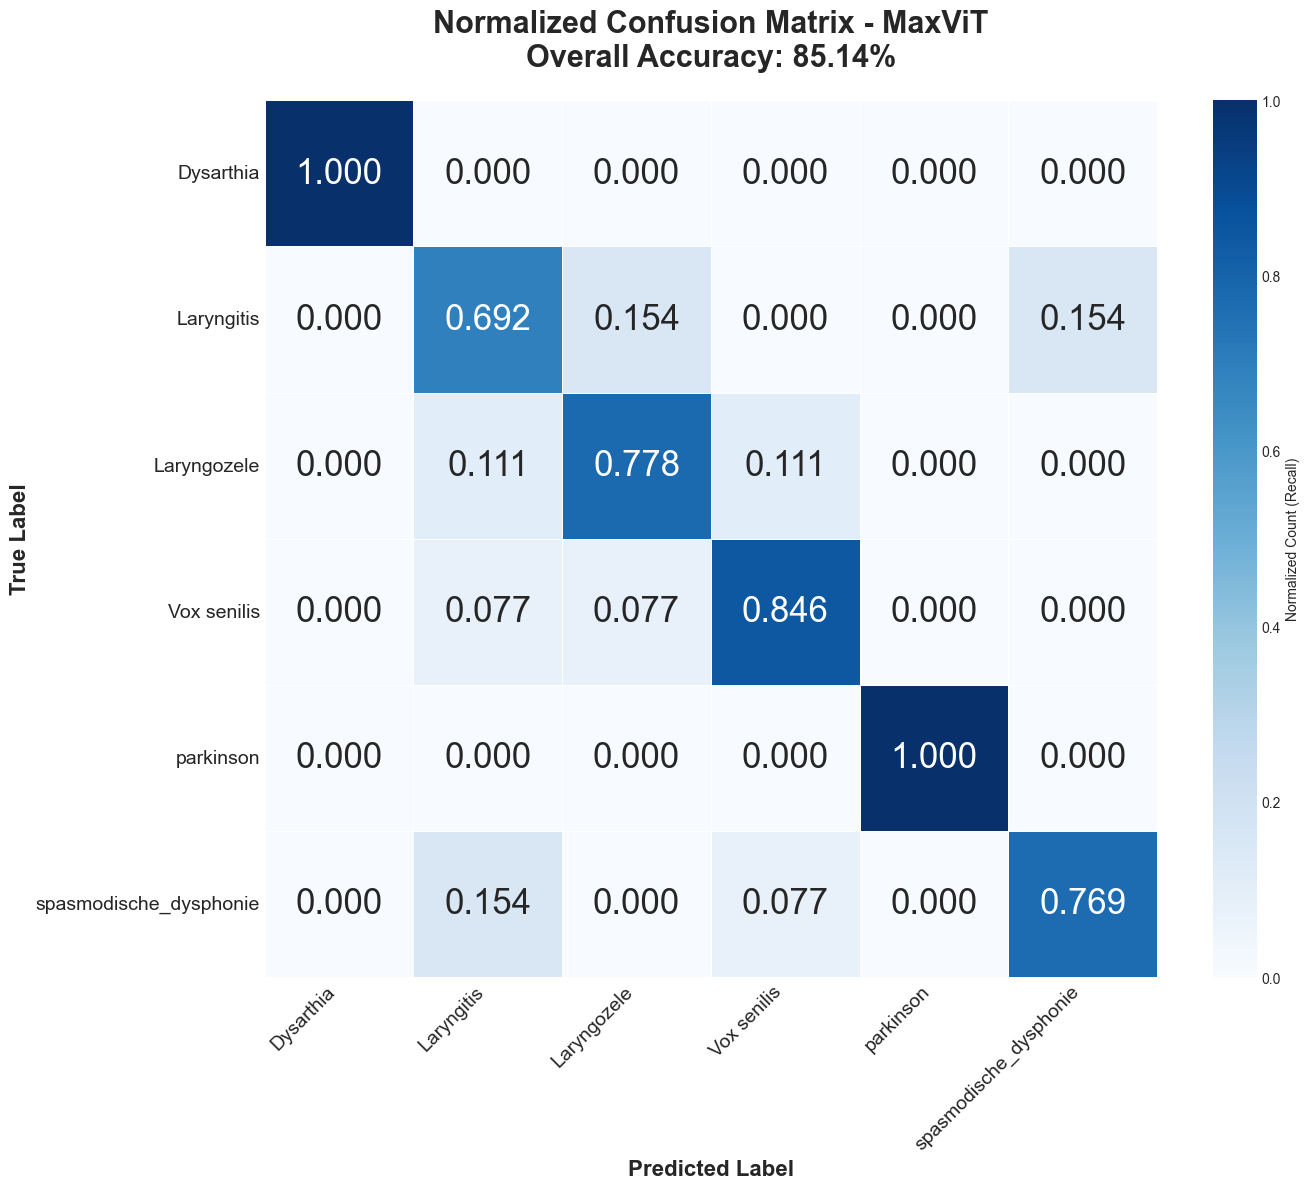

🖼️  HD Normalized Confusion Matrix saved to 'normalized_confusion_matrix_MaxViT_hd.png'

FINAL INDIVIDUAL MODEL ACCURACY SUMMARY
DinoV3    : 85.14%
MaxViT    : 85.14%
EVA-02    : 77.03%


In [5]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL AND HELPER DEFINITIONS
# =============================================================================

class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

def get_test_loader(base_dir, img_size, batch_size, num_workers):
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(test_dataset)} images in the test set.")
    return test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# --- MODIFIED HD PLOTTING FUNCTION ---
# --- UPDATED HD PLOTTING FUNCTION (to show decimals) ---
def plot_hd_confusion_matrix(cm, class_names, model_name, accuracy):
    """Creates and saves a high-definition, NORMALIZED confusion matrix plot with larger text."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 12))
    
    # Normalize the confusion matrix over the true labels (rows)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    heatmap = sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.3f',  # --- MODIFIED: Format as a decimal with 3 places
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 25},
        linewidths=.5,
        cbar_kws={'label': 'Normalized Count (Recall)'}
    )
    
    plt.title(f'Normalized Confusion Matrix - {model_name}\nOverall Accuracy: {accuracy:.2%}', fontsize=22, fontweight='bold', pad=25)
    plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=16, fontweight='bold')
    
    plt.xticks(rotation=45, ha="right", fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    plt.tight_layout()
    
    save_path = f'normalized_confusion_matrix_{model_name}_hd.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"🖼️  HD Normalized Confusion Matrix saved to '{save_path}'")
def evaluate_single_model(model, model_name, test_loader, class_names, device):
    """Runs a full evaluation and calls the new HD plotting function."""
    print(f"\n{'='*60}\nEVALUATING: {model_name}\n{'='*60}")
    model.to(device)
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nResults for {model_name}:")
    print(f"  -> Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Calculate and plot the HD confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_hd_confusion_matrix(cm, class_names, model_name, accuracy)
    
    return accuracy

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    test_loader, class_names = get_test_loader(config['base_dir'], config['img_size'], config['batch_size'], config['num_workers'])
    num_classes = len(class_names)
    results = {}

    # --- Evaluate DinoV3 ---
    dino_model = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(dino_model, config['dino_model_path'], device)
    acc_dino = evaluate_single_model(dino_model, "DinoV3", test_loader, class_names, device)
    results['DinoV3'] = acc_dino

    # --- Evaluate EVA-02 ---
    # MODIFICATION: EVA-02 from timm doesn't have a separate classifier head by default. 
    # The num_classes is passed directly.
    eva_model = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(eva_model, config['eva_model_path'], device)
    acc_eva = evaluate_single_model(eva_model, "EVA-02", test_loader, class_names, device)
    results['EVA-02'] = acc_eva
    
    # --- Evaluate MaxViT ---
    maxvit_model = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(maxvit_model, config['maxvit_model_path'], device)
    acc_maxvit = evaluate_single_model(maxvit_model, "MaxViT", test_loader, class_names, device)
    results['MaxViT'] = acc_maxvit

    # --- Final Summary ---
    print("\n" + "="*60 + "\nFINAL INDIVIDUAL MODEL ACCURACY SUMMARY\n" + "="*60)
    for name, acc in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print(f"{name:<10}: {acc:.2%}")